# Homeworks
1. Find the answer to the question raised in the lab1

    Some helpful resources:
- DeepWalk: https://arxiv.org/pdf/1403.6652.pdf
- Word2vec: https://arxiv.org/pdf/1301.3781.pdf
- Repository Github of Word2vec at [this link](https://github.com/RaRe-Technologies/gensim)
2. Implement a simple word2vec algorithm for the DeepWalk (Attributes for each node should be created).
3. Use some libraries to solve a real problem

# Answer

## Implement Word2vec

### Download data and install packages

In [1]:
!pip install karateclub==1.2.0
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.8 MB/s eta 0:00:00
  Created wheel for karateclub: filename=karateclub-1.2.0-py3-none-any.whl size=94310 sha256=d5bc2488fea645a66bae8f7e41788ac15404cbf1787d0143e1a79a080024c4ce
  Stored in directory: /root/.cache/pip/wheels/17/75/a8/d13d2d4774d6919465fdffb4053d43c0d6cbf764504d13d254
Successfully built karateclub


In [2]:
!pip install numpy==1.23.5
!pip install scipy==1.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 54.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 12.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currentl

In [3]:
!gdown --id "1RmrHId0d-uY7kJCSgCtNYbwYfp4Oum3c&export=download"
!unrar x -Y "/content/lab3.rar" -d "/content/"

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RmrHId0d-uY7kJCSgCtNYbwYfp4Oum3c&export=download
To: /content/lab3.rar
100% 1.54M/1.54M [00:00<00:00, 28.1MB/s]

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/lab3.rar

Extracting  /content/lab3_attributes.csv                                   0%  OK 
Extracting  /content/facebook_features.json                               28%  OK 
Extracting  /content/facebook_target.csv                                  59%  OK 
Extracting  /content/lab3_edgelist.txt                                    59%  OK 
Extracting  /content/facebook_edges.csv                                  100%  OK 
All OK


### Packages

In [4]:
# Task 1
import networkx as nx
from joblib import Parallel, delayed
import random
import itertools
import numpy as np
import pandas as pd

# Task 2
import json
import umap
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
from karateclub.utils.walker import RandomWalker
from gensim.models.word2vec import Word2Vec
import seaborn as sns

### Utils

In [5]:
def partition_num(num, workers):
    if num % workers == 0:
        return [num//workers]*workers
    else:
        return [num//workers]*workers + [num % workers]

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def get_attributes_of_node(node_paths):
  node_paths_attributes = []
  # Get attribute (word) for each node
  df_attr = pd.read_csv("lab3_attributes.csv").astype(str)
  dict_attr = {}
  for i in range(len(df_attr)):
    dict_attr[df_attr.iloc[i, 0]] = df_attr.iloc[i, 1]
  for path in node_paths:
    for index, node in enumerate(path):
      path[index] = dict_attr[node]
    node_paths_attributes.append(path)
  return node_paths_attributes

def preprocessing(sentences):
    training_data = []
    for sentence in sentences:
        x = [word for word in sentence]
        training_data.append(x)
    return training_data


def prepare_data_for_training(sentences,w2v):
    data = {}
    for sentence in sentences:
        for word in sentence:
            if word not in data:
                data[word] = 1
            else:
                data[word] += 1
    V = len(data)
    data = sorted(list(data.keys()))
    vocab = {}
    for i in range(len(data)):
        vocab[data[i]] = i

    for sentence in sentences:
        for i in range(len(sentence)):
            center_word = [0 for x in range(V)]
            center_word[vocab[sentence[i]]] = 1
            context = [0 for x in range(V)]

            for j in range(i-w2v.window_size,i+w2v.window_size):
                if i!=j and j>=0 and j<len(sentence):
                    context[vocab[sentence[j]]] += 1
            w2v.X_train.append(center_word)
            w2v.y_train.append(context)
    w2v.initialize(V,data)

    return w2v.X_train,w2v.y_train

### TO DO

In [6]:
class word2vec():
    def __init__(self, window_size, epochs, embedding_dims=50, learning_rate=0.01):
        # Khởi tạo các tham số cơ bản
        self.window_size = window_size
        self.epochs = epochs
        self.embedding_dims = embedding_dims  # Kích thước của vector nhúng
        self.learning_rate = learning_rate

        # Các danh sách này sẽ được điền bởi hàm prepare_data_for_training
        self.X_train = []  # Input (one-hot center word)
        self.y_train = []  # Target (summed-hot context words)

        # Trọng số sẽ được khởi tạo sau
        self.W1 = None  # Ma trận trọng số Input -> Hidden (V, D)
        self.W2 = None  # Ma trận trọng số Hidden -> Output (D, V)
        self.V = None   # Kích thước từ vựng

        # Từ điển để tra cứu
        self.word_to_index = {}
        self.index_to_word = {}

    def initialize(self, V, data):
        """
        Khởi tạo các ma trận trọng số và từ điển tra cứu.
        Hàm này được gọi bởi `prepare_data_for_training`.
        """
        self.V = V

        # Khởi tạo trọng số ngẫu nhiên cho 2 ma trận
        # W1 là ma trận nhúng đầu vào (Input embedding matrix)
        self.W1 = np.random.randn(self.V, self.embedding_dims) * 0.01
        # W2 là ma trận nhúng đầu ra (Output context matrix)
        self.W2 = np.random.randn(self.embedding_dims, self.V) * 0.01

        # Xây dựng từ điển tra cứu
        for i, word in enumerate(data):
            self.word_to_index[word] = i
            self.index_to_word[i] = word
        print(f"Vocabulary size: {self.V}")

    def train(self):
        """
        Huấn luyện mô hình Word2Vec.
        """
        # Chuyển đổi danh sách training data sang numpy array để tính toán
        self_x = np.array(self.X_train)
        self_y = np.array(self.y_train)

        print(f"Bắt đầu huấn luyện với {len(self_x)} mẫu...")

        for epoch in range(self.epochs):
            total_loss = 0

            # Lặp qua từng cặp (từ trung tâm, từ ngữ cảnh)
            for i in range(len(self_x)):
                x_one_hot = self_x[i]  # Input: [0, 0, 1, 0, ...]
                y_true = self_y[i]     # Target: [0, 1, 0, 2, ...] (summed context)

                # --- 1. QUÁ TRÌNH TRUYỀN THUẬN (FORWARD PASS) ---

                # Tìm chỉ số của từ input (từ 1 trong vector one-hot)
                input_word_index = np.argmax(x_one_hot)

                # a. Input -> Hidden (h = W1[input_word_index])
                # Đây chính là vector nhúng của từ trung tâm
                h = self.W1[input_word_index]  # Shape (D,)

                # b. Hidden -> Output (u = h @ W2)
                # Tính toán score cho tất cả các từ trong từ vựng
                u = np.dot(h, self.W2)  # Shape (V,)

                # c. Áp dụng Softmax để ra xác suất
                # y_pred là phân phối xác suất dự đoán của các từ ngữ cảnh
                y_pred = softmax(u)  # Shape (V,)

                # --- 2. TÍNH TOÁN LOSS (CROSS-ENTROPY) ---
                # Loss = -sum(y_true * log(y_pred))
                loss = -np.sum(y_true * np.log(y_pred + 1e-9)) # Thêm 1e-9 để tránh log(0)
                total_loss += loss

                # --- 3. LAN TRUYỀN NGƯỢC (BACKPROPAGATION) ---

                # a. Tính gradient tại lớp output (dL/du)
                # Đạo hàm của (Softmax + CrossEntropy) là (y_pred - y_true)
                e = y_pred - y_true  # Error gradient, shape (V,)

                # b. Tính gradient cho W2 (dL/dW2 = h.T @ e)
                # Dùng np.outer để nhân vector (D,) với (V,) ra ma trận (D, V)
                grad_W2 = np.outer(h, e)  # Shape (D, V)

                # c. Tính gradient cho lớp ẩn h (dL/dh = e @ W2.T)
                grad_h = np.dot(e, self.W2.T)  # Shape (D,)

                # d. Tính gradient cho W1 (dL/dW1)
                # Vì input x là one-hot, ta chỉ cần cập nhật hàng (row)
                # tương ứng với từ input (input_word_index) trong W1.
                # Gradient của hàng đó chính là grad_h.

                # --- 4. CẬP NHẬT TRỌNG SỐ (GRADIENT DESCENT) ---
                self.W2 -= self.learning_rate * grad_W2
                self.W1[input_word_index] -= self.learning_rate * grad_h

            # In ra loss trung bình sau mỗi 10 epochs
            if (epoch + 1) % 10 == 0 or epoch == 0:
                avg_loss = total_loss / len(self_x)
                print(f"Epoch {epoch+1}/{self.epochs}, Average Loss: {avg_loss:.4f}")

    def _cosine_similarity(self, v1, v2):
        """Tính độ tương đồng cosine giữa 2 vector."""
        dot_product = np.dot(v1, v2)
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)

        if norm_v1 == 0 or norm_v2 == 0:
            return 0.0
        return dot_product / (norm_v1 * norm_v2)

    def predict(self, word, num_similar_words=3):
        """
        Tìm các từ tương đồng nhất với `word` dựa trên cosine similarity.
        Chúng ta sử dụng ma trận nhúng đầu vào (W1) để so sánh.
        """
        if word not in self.word_to_index:
            return f"'{word}' không có trong từ vựng."

        # Lấy vector nhúng của từ input (từ W1)
        input_vector = self.W1[self.word_to_index[word]]

        similarities = {}
        # Lặp qua tất cả các từ trong từ vựng để so sánh
        for i in range(self.V):
            if i == self.word_to_index[word]:
                continue  # Bỏ qua, không so sánh từ với chính nó

            other_word = self.index_to_word[i]
            other_vector = self.W1[i]

            # Tính cosine similarity
            sim = self._cosine_similarity(input_vector, other_vector)
            similarities[other_word] = sim

        # Sắp xếp các từ theo độ tương đồng giảm dần
        sorted_similar = sorted(similarities.items(), key=lambda item: item[1], reverse=True)

        # Trả về top `num_similar_words`
        return sorted_similar[:num_similar_words]

### DeepWalk

In [7]:
class RandomWalker:
  def __init__(self, G, num_walks, walk_length):
      """
      :param G: Graph
      :param num_walks: a number of walks
      :param walk_length: Length of a walk. Each walk is considered as a sentence
      """
      self.G = G
      self.num_walks = num_walks
      self.walk_length = walk_length


  def deepwalk_walk(self, start_node):
      """
      :param start_node: Starting node of a walk
      """
      walk = [start_node]
      while len(walk) < self.walk_length:
          cur = walk[-1]
          # Check if having any neighbors at the current node
          cur_nbrs = list(self.G.neighbors(cur))
          if len(cur_nbrs) > 0:
              # Random walk with the probability of 1/d(v^t). d(v^t) is the node degree
              walk.append(random.choice(cur_nbrs))
          else:
              break
      return walk


  def simulate_walks(self, workers=1, verbose=0):
      """
      :param workers: a number of workers running in parallel processing
      :param verbose: progress bar
      """
      G = self.G
      nodes = list(G.nodes())
      results = Parallel(n_jobs=workers, verbose=verbose)(
          delayed(self._simulate_walks)(nodes) for num in
          partition_num(self.num_walks, workers))
      walks = list(itertools.chain(*results))
      return walks


  # INFORMATION EXTRACTOR
  def _simulate_walks(self, nodes):
      walks = []
      # Iterate all walks per vertex
      for _ in range(self.num_walks):
          random.shuffle(nodes)
          # Iterate all nodes in a walk
          for v in nodes:
            walks.append(self.deepwalk_walk(start_node=v))
      return walks

In [8]:
class DeepWalk:
    def __init__(self, graph, walk_length, num_walks, workers=1):

        self.graph = graph
        self.w2v_model = None
        self._embeddings = {}

        self.walker = RandomWalker(graph, num_walks=num_walks, walk_length=walk_length)
        self.walks = self.walker.simulate_walks(workers=workers, verbose=1)
        self.sentences = get_attributes_of_node(self.walks)


    def train(self, window_size=5, epochs=100):
        print("Learning embedding vectors...")
        training_data = preprocessing(self.sentences)
        w2v = word2vec(window_size, epochs)
        prepare_data_for_training(training_data, w2v)
        w2v.train()
        print("Learning embedding vectors done!")
        self.w2v_model = w2v


    def test(self, word):
        print(self.w2v_model.predict(word,3))

### Run graph embedding

In [9]:
G = nx.read_edgelist('lab3_edgelist.txt',create_using=nx.DiGraph(),nodetype=None,data=[('weight',int)])# Read graph
model = DeepWalk(G, walk_length=3, num_walks=10, workers=1)#init model
model.train(window_size=5)# train model

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Learning embedding vectors...
Vocabulary size: 18
Bắt đầu huấn luyện với 690 mẫu...
Epoch 1/100, Average Loss: 5.7799
Epoch 10/100, Average Loss: 6.6048
Epoch 20/100, Average Loss: 34.2794
Epoch 30/100, Average Loss: 34.9893
Epoch 40/100, Average Loss: 35.3197
Epoch 50/100, Average Loss: 35.3797
Epoch 60/100, Average Loss: 34.8391
Epoch 70/100, Average Loss: 35.3797
Epoch 80/100, Average Loss: 35.3497
Epoch 90/100, Average Loss: 35.7702
Epoch 100/100, Average Loss: 34.8691
Learning embedding vectors done!


In [10]:
print(model.sentences)
model.test("to")
model.test("this")

[['lab', 'happy', 'that'], ['the', 'so', 'lab'], ['best', 'I', 'to'], ['!', 'am', 'am'], ['this', 'this', 'I'], ['in', 'all', 'you'], ['I', 'to', 'happy'], ['that', 'this', 'I'], ['happy', 'that', 'you'], ['wish', 'all', 'this'], ['learned', 'I', 'am'], ['.', 'so', 'I'], ['you', '.', 'so'], ['something', 'happy', 'wish'], ['I', 'happy', 'that'], ['you', 'to', 'lab'], ['all', 'all', 'to'], ['this', 'so', '!'], ['to', 'happy', 'that'], ['lab', '.', 'so'], ['am', 'am', 'am'], ['so', '!', 'am'], ['.', '.', 'so'], ['something', 'happy', 'wish'], ['lab', '.', 'happy'], ['this', 'this', 'I'], ['learned', '!', 'I'], ['all', 'all', 'this'], ['happy', 'that', 'you'], ['lab', 'happy', 'wish'], ['wish', 'you', 'to'], ['this', 'I', 'am'], ['in', 'all', 'all'], ['.', '.', 'so'], ['I', 'happy', 'that'], ['am', 'am', 'that'], ['so', 'lab', 'happy'], ['best', 'I', 'you'], ['.', 'so', 'lab'], ['you', 'to', 'happy'], ['the', 'so', '!'], ['!', 'so', 'that'], ['I', 'to', 'lab'], ['you', 'that', 'this'], ['

## TO DO: Solve a real problem using some libraries

Goal: When we have a large graph dataset like the Facebook dataset below, we want to classify which company (node) will likely belong to a type of page. If we categorize well, we could apply marketing strategies in a domain on a company that we are surveying.
Therefore, our task is to learn a model which can classify a company using related features.


1. Analyze and visualize the dataset Facebook downloaded in [this website](https://snap.stanford.edu/data/facebook-large-page-page-network.html).
2. Use DeepWalk to embed the graph
3. Train a classifier to do the node classification task using the embedding graph from step 2.

You can do many things with the data. I recommend that you could try many tasks with this data, not only the classification task.

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from karateclub import DeepWalk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import umap

### Read data

In [23]:
edges_path = '/content/facebook_edges.csv'
targets_path = '/content/facebook_target.csv'
features_path = '/content/facebook_features.json'

### Visualize datasets

Create a graph. If you want to use smaller graph, please try to create one. It will be lighter when running the code.

--- Thông tin đồ thị Facebook ---
Graph with 22472 nodes and 170824 edges
---------------------------------

--- Phân phối các loại Page ---
page_type
government    30.618603
company       28.905207
politician    25.669782
tvshow        14.806409
Name: proportion, dtype: float64
---------------------------------


/tmp/ipython-input-2791336628.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='page_type', data=targets, order=targets['page_type'].value_counts().index, palette='viridis')


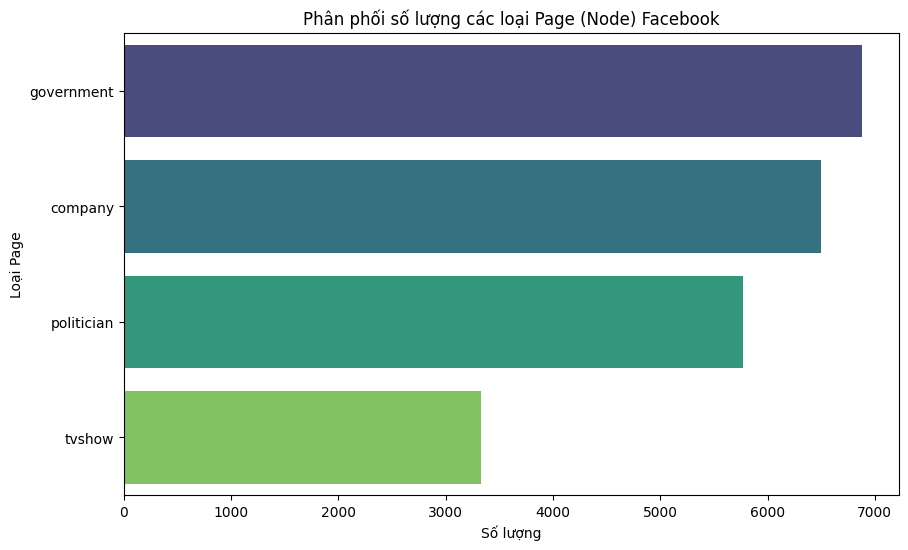

In [24]:
# Đọc dữ liệu
# SỬA LỖI: Thêm header=None (vì file gốc không có tiêu đề)
# và names=['node_1', 'node_2'] để đặt tên cho các cột.
edges = pd.read_csv(edges_path, header=None, names=['node_1', 'node_2'])
targets = pd.read_csv(targets_path)

# Tạo đồ thị từ danh sách cạnh (edges)
# Bây giờ DataFrame 'edges' đã có cột 'node_1' và 'node_2'
G_fb = nx.from_pandas_edgelist(edges, 'node_1', 'node_2', create_using=nx.Graph())

# Xóa các cạnh tự lặp (self-loops) nếu có
G_fb.remove_edges_from(nx.selfloop_edges(G_fb))

# In thông tin cơ bản của đồ thị
print("--- Thông tin đồ thị Facebook ---")
# SỬA LỖI: nx.info() đã bị loại bỏ, thay bằng print(G_fb)
print(G_fb)
print("---------------------------------")

# Phân tích và trực quan hóa các lớp (labels)
print("\n--- Phân phối các loại Page ---")
print(targets['page_type'].value_counts(normalize=True) * 100)
print("---------------------------------")

# Vẽ biểu đồ phân phối
plt.figure(figsize=(10, 6))
sns.countplot(y='page_type', data=targets, order=targets['page_type'].value_counts().index, palette='viridis')
plt.title('Phân phối số lượng các loại Page (Node) Facebook')
plt.xlabel('Số lượng')
plt.ylabel('Loại Page')
plt.show()

### Embedding graph using DeepWalk

Embedding graph using DeepWalk

In [25]:
# 1. SỬA LỖI: Relabel đồ thị (Graph)
# karateclub yêu cầu các node phải được index là 0, 1, 2, ...
# Chúng ta dùng nx.convert_node_labels_to_integers để tạo graph mới
# ordering='default' sẽ sắp xếp các node (theo ID) và gán index 0, 1, 2...
print("Đang relabel đồ thị cho karateclub...")
G_fb_relabeled = nx.convert_node_labels_to_integers(G_fb, first_label=0, ordering='default')

# Lấy danh sách các node gốc THEO ĐÚNG THỨ TỰ mà G_fb_relabeled đã dùng
# (Thứ tự này rất quan trọng để map embedding trở lại)
original_nodes_sorted = sorted(G_fb.nodes())

# 2. Khởi tạo mô hình DeepWalk
dw_model = DeepWalk(walk_length=20, dimensions=128, window_size=5)

# 3. Huấn luyện mô hình trên đồ thị ĐÃ RELABEL
print("Bắt đầu huấn luyện DeepWalk...")
dw_model.fit(G_fb_relabeled)
print("Hoàn thành huấn luyện DeepWalk.")

# 4. Lấy ra các vector nhúng
embedding = dw_model.get_embedding()
print(f"Kích thước ma trận nhúng: {embedding.shape}")

# 5. Tạo DataFrame từ các vector nhúng
# QUAN TRỌNG: Index của DataFrame phải là các ID node GỐC
# (theo đúng thứ tự đã sắp xếp ở trên) để có thể join với file targets
embedding_df = pd.DataFrame(embedding, index=original_nodes_sorted)

print("\n5 vector nhúng đầu tiên:")
print(embedding_df.head())

Đang relabel đồ thị cho karateclub...
Bắt đầu huấn luyện DeepWalk...


Hoàn thành huấn luyện DeepWalk.
Kích thước ma trận nhúng: (22472, 128)

5 vector nhúng đầu tiên:
           0         1         2         3         4         5         6    \
0    -0.249614  0.011436 -0.824398  1.024366  0.034894 -0.766959  0.041550   
1    -0.224011 -0.029153 -0.864989  1.073998 -0.001595 -0.806142  0.067983   
10   -0.155081 -0.064018  0.447960  0.176073  0.708768  0.224688  0.081398   
100  -0.469270 -0.080300 -0.238921  0.418968  1.679292  0.624160 -0.369380   
1000  0.037187  0.260697  0.875331 -0.716165  0.188840 -0.852751 -0.832341   

           7         8         9    ...       118       119       120  \
0     0.384934 -0.948553 -0.768451  ...  0.112834  0.522240 -0.053936   
1     0.413051 -1.010225 -0.789432  ...  0.077324  0.577631 -0.078116   
10   -0.309155 -0.375745  0.342096  ... -0.015234  0.250568  0.205617   
100  -0.056219 -0.174412  0.298924  ...  1.223585  1.067981  0.500694   
1000  0.085514  0.237441 -0.156248  ...  0.284689  0.356987  0.901909

### Train a classifier

Train a classifer from the embedding graph to the target. Here we use the Random Forest classifier.

Đang chuẩn bị dữ liệu...
Đã ép kiểu ID sang string để join.
Số lượng node dùng để huấn luyện (sau khi join): 22470
Số lượng features (chiều embedding): 128
Kích thước tập Train: 17976
Kích thước tập Test: 4494

Bắt đầu huấn luyện Random Forest Classifier...
Hoàn thành huấn luyện.

--- Kết quả đánh giá mô hình ---
Weighted F1 Score: 0.2536
Macro F1 Score: 0.2197
---------------------------------

Trực quan hóa Confusion Matrix:


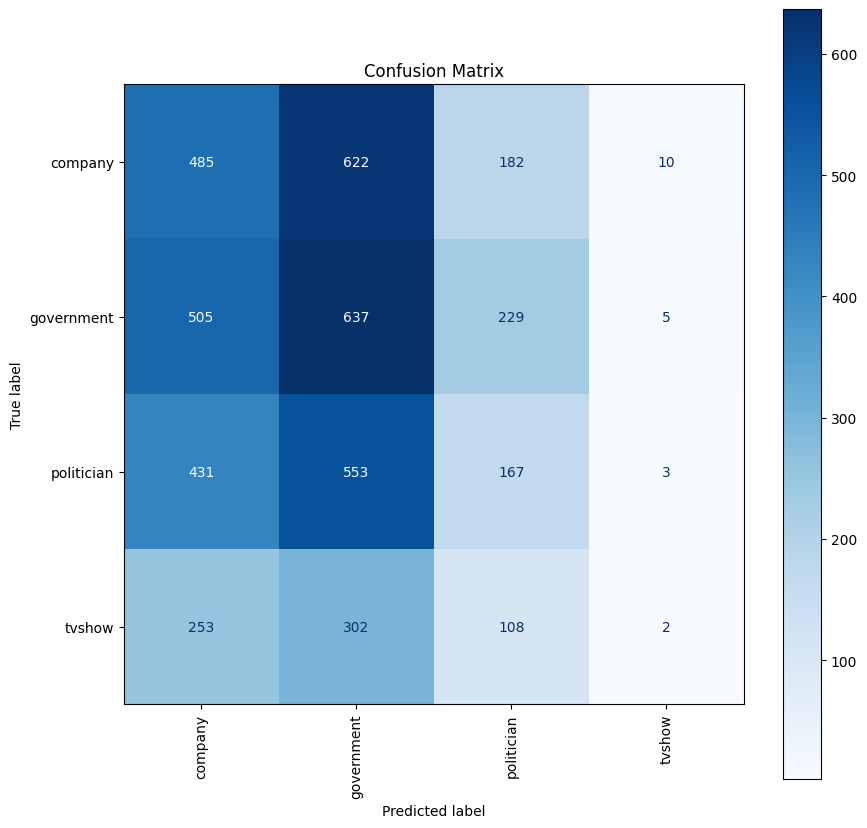


Trực quan hóa không gian nhúng bằng UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


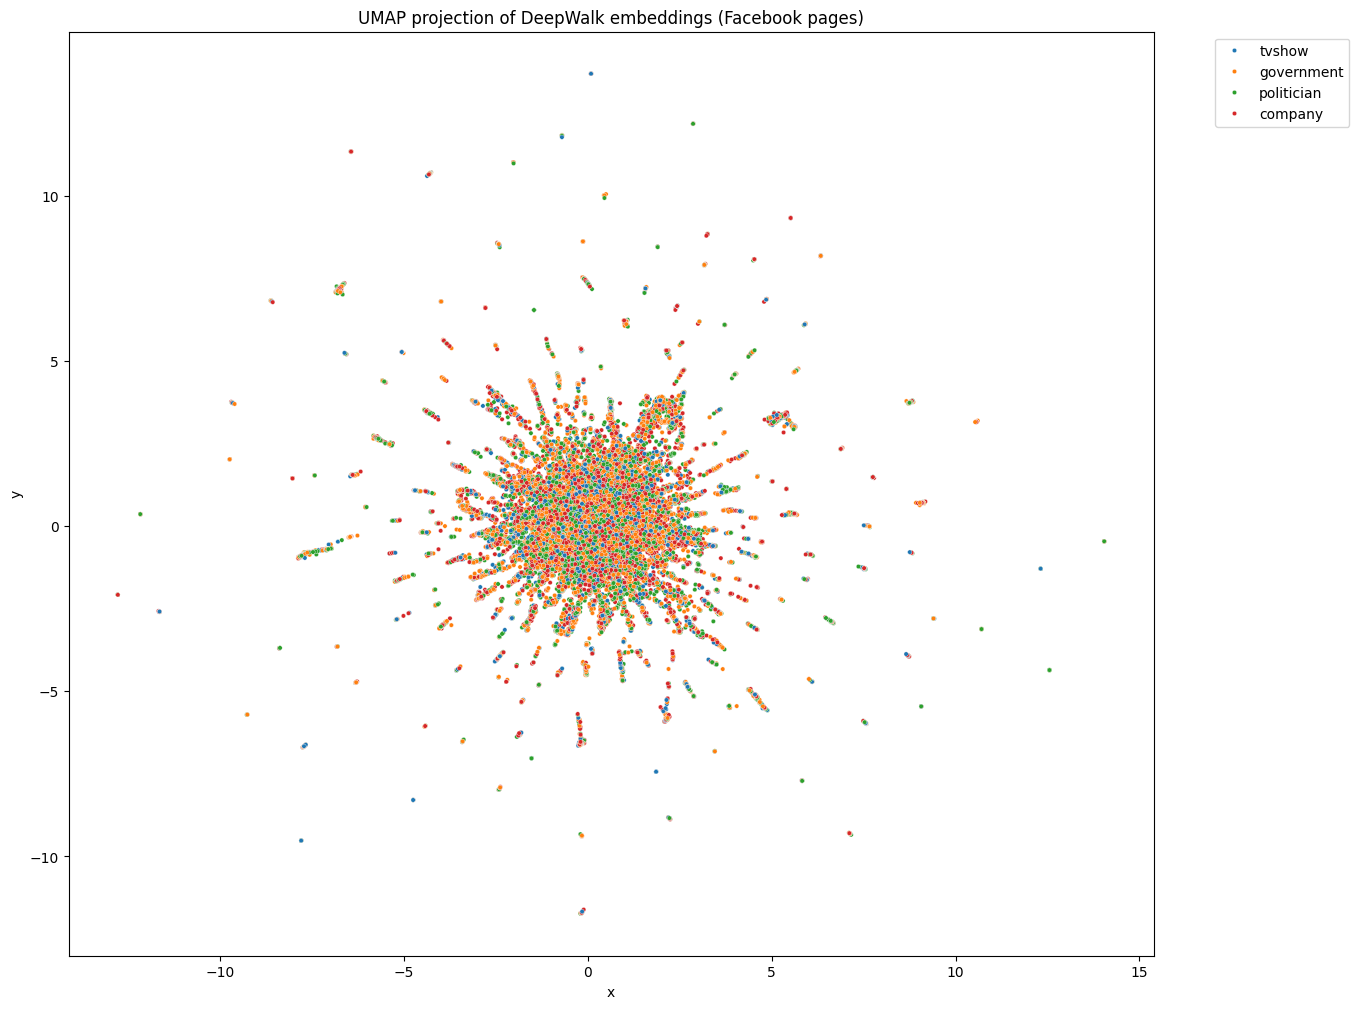

In [29]:
# 1. Chuẩn bị dữ liệu cho mô hình ML
print("Đang chuẩn bị dữ liệu...")

try:
    # 1a. Chuyển index của embedding_df (từ node gốc) sang str
    embedding_df.index = embedding_df.index.astype(str)

    # 1b. Chuyển cột 'id' của targets sang str TRƯỚC KHI set index
    targets['id'] = targets['id'].astype(str)
    targets_df = targets.set_index('id')

    print("Đã ép kiểu ID sang string để join.")

except Exception as e:
    print(f"Lỗi khi ép kiểu index: {e}")

# Ghép (join) DataFrame nhúng và DataFrame nhãn
data_df = embedding_df.join(targets_df, how='inner')

# Loại bỏ các hàng có giá trị NaN (nếu có)
data_df = data_df.dropna()

print(f"Số lượng node dùng để huấn luyện (sau khi join): {data_df.shape[0]}")

# 2. Tách X (features) và y (labels)

# SỬA LỖI: Chỉ chọn các cột là embedding làm feature (X)
# Các cột embedding có tên là số nguyên từ 0 đến 127 (do DeepWalk tạo ra)
# Chúng ta sẽ lọc lấy các cột này.
embedding_columns = embedding_df.columns
X = data_df[embedding_columns]

# Ép kiểu tên cột sang string để tránh lỗi TypeError của sklearn
X.columns = X.columns.astype(str)

# Lấy cột nhãn (target)
y = data_df['page_type']

print(f"Số lượng features (chiều embedding): {X.shape[1]}")


# 3. Kiểm tra và huấn luyện
if data_df.shape[0] == 0:
    print("\n!!! LỖI NGHIÊM TRỌNG !!!")
    print("Không tìm thấy node chung nào giữa file 'edges' và file 'target'.")
else:
    # Chia tập train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Kích thước tập Train: {X_train.shape[0]}")
    print(f"Kích thước tập Test: {X_test.shape[0]}")

    # Huấn luyện mô hình
    print("\nBắt đầu huấn luyện Random Forest Classifier...")
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    print("Hoàn thành huấn luyện.")

    # Đánh giá mô hình
    y_pred = clf.predict(X_test)

    print("\n--- Kết quả đánh giá mô hình ---")
    f1_w = f1_score(y_test, y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1_w:.4f}")
    f1_m = f1_score(y_test, y_pred, average='macro')
    print(f"Macro F1 Score: {f1_m:.4f}")
    print("---------------------------------")

    # Trực quan hóa Confusion Matrix
    print("\nTrực quan hóa Confusion Matrix:")
    labels = clf.classes_
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # Trực quan hóa UMAP
    print("\nTrực quan hóa không gian nhúng bằng UMAP...")
    # Lấy mẫu nhỏ hơn nếu dữ liệu quá lớn để vẽ nhanh hơn (tùy chọn)
    # Ở đây vẽ toàn bộ 22k điểm có thể hơi lâu nhưng sẽ đầy đủ.
    reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
    embedding_2d = reducer.fit_transform(X)

    df_2d = pd.DataFrame(embedding_2d, columns=['x', 'y'])
    df_2d['label'] = y.values

    plt.figure(figsize=(14, 12))
    sns.scatterplot(data=df_2d, x='x', y='y', hue='label', s=10, palette='tab10')
    plt.title('UMAP projection of DeepWalk embeddings (Facebook pages)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()

# THANK YOU
Please dive more into the codes and papers if you are interested.

Thank you for joining all the labs.